### Face recognition with Keras, Dlib and OpenCV

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras import backend as K

import cv2
import os.path
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
#
from inception_block import *
from face_detection_landmarks_alignment import *
from keras.models import model_from_json

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import sys
import dlib
from skimage import io

from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

import warnings

Using TensorFlow backend.


#### Architecture Description
CNN architecture used here is a variant of the inception architecture. It is a variant of the NN4 architecture described in and identified as *nn4.small2* model in the openface project. The key part of the architecture are the top two layers referred as the embedding layer from which the 128-dimensional embedding vectors can be obtained.

The complete model is defined in *inception_block.py*. 

In [2]:
FRModel = create_model()
print("Total Params:", FRModel.count_params())
FRModel.load_weights('weights/nn4.small2.v1.h5')

Total Params: 3743280


#### Custom Dataset
The metadata for each image (file and identity name) are loaded into memory for later processing.

In [3]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)


def load_metadata(path):
    metadata = []
    num_person = 0
    for i in sorted(os.listdir(path)):
        num_person += 1
        for f in sorted(os.listdir(os.path.join(path, i))):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.JPG' or ext == '.jpeg' or ext == '.jpg' or ext == 'JPEG':
                metadata.append(IdentityMetadata(path, i, f))
    return (np.array(metadata), num_person)


metadata, num_person = load_metadata('images')
# print(metadata)

#### 128 dimensional embedding vectors
For each image in the custom dataset below code loads the path, converts from BGR to RGB order, aligns, scales and finally calculate the 128 dimensional embedding vectors.

In [4]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[..., ::-1]


embedded = np.zeros((metadata.shape[0], 128))

for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img = align_image(img)
    # scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
    embedded[i] = FRModel.predict(np.expand_dims(img, axis=0))[0]

#### L2 Distance Calculation on few examples 

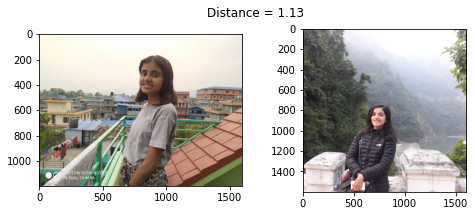

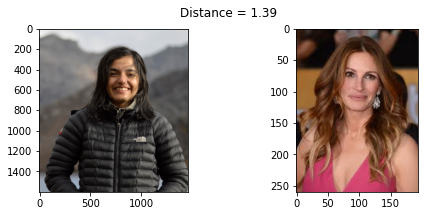

In [5]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))


def show_pair(idx1, idx2):
    plt.figure(figsize=(8, 3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))


show_pair(25, 8)
show_pair(2, 30)

#### Distance threshold
To find the optimal value for threshold, face verification performance must be evaluated on a range of distance threshold values. At a given threshold, all possible embedding vector pairs are classified as either same identity or different identity and compared to the ground truth. Since we’re dealing with skewed classes (much more negative pairs than positive pairs), we use the F1 score as evaluation metric instead of accuracy.

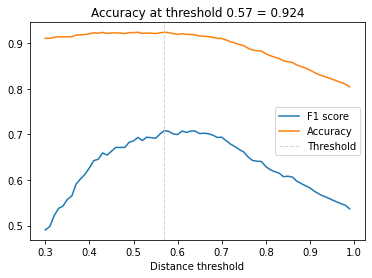

In [6]:
distances = []  # squared L2 distance between pairs
identical = []  # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(i + 1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)

distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score')
plt.plot(thresholds, acc_scores, label='Accuracy')
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}')
plt.xlabel('Distance threshold')
plt.legend()

#### Training and testing 
For training 50% of the dataset is used and the remaining 50% for evaluation. Two approaches are used
    1. Label the input using the top k scoring entries in the database known as KNN classification with euclidean distance metric.
    2. A linear SVM trained with the database entries and used to classify i.e. identify new inputs

In [7]:
targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

#Dividing the images into half train and half test set
train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

X_train = embedded[train_idx]
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.9428571428571428, SVM accuracy = 0.9428571428571428


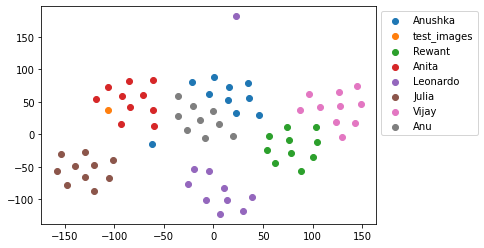

In [8]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)

plt.legend(bbox_to_anchor=(1, 1))

In [9]:
# example_idx = 35

# # example_image = load_image(metadata[test_idx][example_idx].image_path())
# # example_prediction = svc.predict([embedded[test_idx][example_idx]])
# # example_identity = encoder.inverse_transform(example_prediction)[0]

# example_image = load_image(metadata[example_idx].image_path())
# example_prediction = svc.predict([embedded[example_idx]])
# example_identity = encoder.inverse_transform(example_prediction)[0]

# print(embedded[example_idx])
# print(example_prediction)
# plt.imshow(example_image)
# plt.title(f'Recognized as {example_identity}');

#### Face recognition in static images.
The code aligns faces from the provided image, scales, identify it's 128 dimensional embedding vector and then predicts it using the *SVM* classifier, draws the rectangle and then puts the identity of the face beside the rectangle.

In [10]:
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

new_embedded = np.zeros((num_person, 128))
example_prediction = [0] * num_person
example_identity = [None] * num_person

face_detector = dlib.get_frontal_face_detector()

image = io.imread('images/Anita/faces.JPG')

detected_faces = face_detector(image, 1)

for i, face_rect in enumerate(detected_faces):
    img_segment = align_image_new(image, face_rect)
    img_segment = (img_segment / 255.).astype(np.float32)
    new_embedded[i] = FRModel.predict(np.expand_dims(img_segment, axis=0))[0]
    example_prediction[i] = svc.predict([new_embedded[i]])
    example_identity[i] = encoder.inverse_transform(example_prediction[i])[0]

    left = face_rect.left()
    right = face_rect.right()
    top = face_rect.top()
    bottom = face_rect.bottom()

    cv2.rectangle(image, (left, top), (right, bottom), (0, 0, 255), 3)
    y = top - 15 if top - 15 > 15 else top + 15
    cv2.putText(image, example_identity[i], (left, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)

img = cv2.resize(image, (720, 720), interpolation=cv2.INTER_AREA)

final_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.imshow("Image", final_img)
cv2.waitKey(0)

-1

#### Face recognition in webcam videos
This code does all the same functionalities mentioned above for face recognition for static images but on frames of the video captured. 

In [15]:
import cv2
import dlib

new_embedded = np.zeros((num_person, 128))
example_prediction = [0] * num_person
example_identity = [None] * num_person

face_detector = dlib.get_frontal_face_detector()

video_capture = cv2.VideoCapture(0)
face_locations = []
while True:
    ret, frame = video_capture.read()
    rgb_frame = frame[:, :, ::-1]


    face_locations = face_detector(rgb_frame, 1)
    for i, face_rect in enumerate(face_locations):
        img_segment = align_image_new(image, face_rect)
        img_segment = (img_segment / 255.).astype(np.float32)
        new_embedded[i] = FRModel.predict(np.expand_dims(img_segment, axis=0))[0]
        example_prediction[i] = svc.predict([new_embedded[i]])
        example_identity[i] = encoder.inverse_transform(example_prediction[i])[0]

        left = face_rect.left()
        right = face_rect.right()
        top = face_rect.top()
        bottom = face_rect.bottom()

        cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)
        y = top - 15 if top - 15 > 15 else top + 15
        cv2.putText(frame, example_identity[i], (left, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)

    cv2.imshow('Video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()

#### Face recognition on videos

In [16]:
input_movie = cv2.VideoCapture("sample_video.mp4")
length = int(input_movie.get(cv2.CAP_PROP_FRAME_COUNT))

frame_number = 0

new_embedded = np.zeros((num_person, 128))
example_prediction = [0] * num_person
example_identity = [None] * num_person

face_detector = dlib.get_frontal_face_detector()

while True:
    # Grab a single frame of video
    ret, frame = input_movie.read()
    frame_number += 1

    # Quit when the input video file ends
    if not ret:
        break

    # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
    rgb_frame = frame[:, :, ::-1]

    # Find all the faces and face encodings in the current frame of video
    face_locations = face_detector(rgb_frame, 1)

    # Label the results
    for i, face_rect in enumerate(face_locations):
        # Draw a box around the face
        img_segment = align_image_new(rgb_frame, face_rect)
        img_segment = (img_segment / 255.).astype(np.float32)
        new_embedded[i] = FRModel.predict(np.expand_dims(img_segment,
                                                         axis=0))[0]
        example_prediction[i] = svc.predict([new_embedded[i]])
        example_identity[i] = encoder.inverse_transform(
            example_prediction[i])[0]

        left = face_rect.left()
        right = face_rect.right()
        top = face_rect.top()
        bottom = face_rect.bottom()

        cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)
        y = top - 15 if top - 15 > 15 else top + 15
        cv2.putText(frame, example_identity[i], (left, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
    # Display the resulting image
    cv2.imshow('Video', frame)

    # Hit Enter on the keyboard to quit!
    if cv2.waitKey(1) == 13:  #13 is the Enter Key
        break

# All done!
input_movie.release()
cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()